<a href="https://colab.research.google.com/github/sunfflur/frequency-learning/blob/main/Exp_02_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment 02

`Author:` [sunfflur](https://github.com/sunfflur)

> Experiment 02 uses the 28 classes from Kylberg Texture Dataset divided in 75% / 25% with 576x576 pixels of dimension each image and radius equal to 1.



---

#### Libraries Import

In [ ]:
s = 23
import os
os.environ['PYTHONHASHSEED']=str(s)
import random
random.seed(s)
from numpy.random import seed
seed(s)
from tensorflow.random import set_seed
set_seed(s)

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Conv1D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

!pip install tensorflow-addons 
!pip install tensorflow-recommenders

import tensorflow_addons as tfa
import tensorflow_recommenders as tfrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.7 MB/s 


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec  2 00:08:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#### Drive mount

In [ ]:
### TESSSSSST ###

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 124020 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-36build1_amd64.deb ...
Unpacking w3m (0.5.3-36build1) ...
Setting up w3m (0.5.3-36build1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


#### Data preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### data loading ### 
path_train = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_train.npy'
path_ytrain = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_y_train.npy'
path_test = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_test.npy'
path_ytest = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_y_test.npy'

x_train, x_test = np.load(path_train), np.load(path_test)
y_train, y_test = np.load(path_ytrain), np.load(path_ytest)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# adjust dimension and change from array to tensor
new_shape = (576,576)
x_train, x_test = tf.image.resize(x_train, new_shape), tf.image.resize(x_test, new_shape)
y_train, y_test = tf.stack(to_categorical(y_train)), tf.stack(to_categorical(y_test))

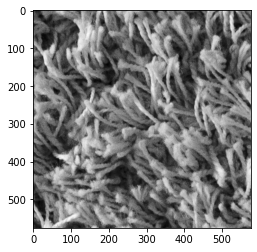

In [ ]:
plt.imshow(tf.squeeze(x_test[0]), cmap='gray') #0-rug1 (controle test)
plt.show()

#### Image Main Functions

In [ ]:
### blocks ###
def slice(image, levels):
  if levels == 0:
    image = tf.transpose(image, [0, 3, 1, 2])
    return image
  iM, iN = image.shape[1], image.shape[2]
  iMc, iNc = int(iM/2), int(iN/2)
  output = tf.stack((image[:, :iMc, :iNc], image[:, :iMc,iNc:], image[:, iMc:,:iNc], image[:, iMc:, iNc:]),-1)
  output = tf.reshape(output,[output.shape[0],output.shape[1],output.shape[2],-1])
  return slice(output, levels-1)

In [ ]:
### DFT ### 
def m_spectrum(image):
  side = image.shape[2]
  inputx = tf.cast(image, tf.complex128) # change dtype to complex64 
  fft = tf.signal.fft2d(inputx) # perform fast fourier transform
  fft_shift = tf.signal.fftshift(fft, axes=(2,3)) # shift the zero-frequency component to the center

  # calculate the magnitude and scale it
  magnitude = tf.math.abs(fft_shift) 
  magnitude = tf.math.divide(magnitude, side**2)
  magnitude = tf.math.log(1+magnitude)

  return magnitude

In [ ]:
### magnitude sums ###
def radial_grouping(image, r):
  iM, iN = image.shape[2], image.shape[3] #image dimension
  iMc, iNc = int(iM/2), int(iN/2) #image center
  A = tf.range(-iMc,iNc)**2
  dists = tf.math.sqrt(tf.cast(A[:,None] + A, dtype=tf.float32))
  dists = tf.reshape(dists, [1,1,image.shape[2],image.shape[3]]) #1,1,128,128
  n = int(iNc/r) #rings number
  r = (r/2)
  magnitude_sums = []
  ring = 0
  for j in range(1, 2*n, 2):
    ring = tf.cast((tf.abs(dists-r*j)<r), dtype=tf.float32)
    if j == 1:
      ring = tf.cast((tf.abs(dists-(r/2)*j)<=(r/2)), dtype=tf.float32)
    mult = tf.multiply(ring,image)
    sum = tf.reduce_sum(mult,axis=(2,3))
    magnitude_sums.append(sum.numpy())
  magnitude_sums = tf.transpose(tf.convert_to_tensor(magnitude_sums))
  magnitude_sums = tf.reshape(magnitude_sums, [magnitude_sums.shape[1], magnitude_sums.shape[2], magnitude_sums.shape[0]])
  magnitude_sums = tf.reshape(magnitude_sums, [magnitude_sums.shape[0], -1])
  return magnitude_sums

In [ ]:
### magnitude sums ###
def square_grouping(image, r):
  iM, iN = image.shape[2], image.shape[3] #img.shape
  iMc, iNc = int(iM/2), int(iN/2) #image center
  n = int(iNc/r) #rings number
  ring = np.full((iM,iN), 0)
  magnitude_sums = []
  for w in range(r, (n*r)+1, r):
    ring[iMc-w:iMc+w,iNc-w:iNc+w] = 1
    ring[iMc-w + r :iMc+w -r ,iNc-w +r :iNc+w -r] = 0
    mult = tf.multiply(ring,image)
    sum = tf.reduce_sum(mult,axis=(2,3))
    magnitude_sums.append(sum.numpy())
  magnitude_sums = tf.transpose(tf.convert_to_tensor(magnitude_sums))
  magnitude_sums = tf.reshape(magnitude_sums, [magnitude_sums.shape[1], magnitude_sums.shape[2], magnitude_sums.shape[0]])
  magnitude_sums = tf.reshape(magnitude_sums, [magnitude_sums.shape[0], -1])
  return magnitude_sums

#### Image Main Functions - Per Image

In [ ]:
### blocks PER IMAGE ###
def slice(images, levels):
  outputs = []
  if levels == 0:
    images = tf.transpose(images, [0, 3, 1, 2])
    return images
  for image in images:
    iM, iN = image.shape[0], image.shape[1] #576,576,1
    iMc, iNc = int(iM/2), int(iN/2) #576/2,576/2
    output = tf.stack((image[:iMc, :iNc], image[:iMc,iNc:], image[iMc:,:iNc], image[iMc:, iNc:]),-1)
    output = tf.reshape(output,[output.shape[0],output.shape[1],-1]) #288,288,4
    outputs.append(output)
  outputs = tf.convert_to_tensor(outputs)
  return slice(outputs, levels-1)

In [ ]:
### DFT PER IMAGE ### 
def m_spectrum(images):
  magnitudes = []
  for image in images:
    side = image.shape[1]
    inputx = tf.cast(image, tf.complex128) # change dtype to complex64 
    fft = tf.signal.fft2d(inputx) # perform fast fourier transform
    fft_shift = tf.signal.fftshift(fft, axes=(1,2)) # shift the zero-frequency component to the center

    # calculate the magnitude and scale it
    magnitude = tf.math.abs(fft_shift) 
    magnitude = tf.math.divide(magnitude, side**2)
    magnitude = tf.math.log(1+magnitude)
    magnitudes.append(magnitude)
  return tf.convert_to_tensor(magnitudes)

In [ ]:
### magnitude sums PER IMAGE ###
def radial_grouping(images, r):
  grouping = []
  for image in images:
    iM, iN = image.shape[1], image.shape[2] #image dimension
    iMc, iNc = int(iM/2), int(iN/2) #image center
    A = tf.range(-iMc,iNc)**2
    dists = tf.math.sqrt(tf.cast(A[:,None] + A, dtype=tf.float64))
    dists = tf.reshape(dists, [1,image.shape[1],image.shape[2]]) #1,512,512
    n = int(iNc/r) #rings number
    magnitude_sums = []
    ring = 0
    for j in range(1, 2*n, 2):
      ring = tf.cast((tf.abs(dists-(r/2)*j)<(r/2)), dtype=tf.float64)
      if j == 1:
        ring = tf.cast((tf.abs(dists-(r/2)*j)<=(r/2)), dtype=tf.float64)
      mult = tf.multiply(ring,image)
      sum = tf.reduce_sum(mult,axis=(1,2))
      magnitude_sums.append(sum.numpy())
    magnitude_sums = tf.convert_to_tensor(magnitude_sums)
    grouping.append(magnitude_sums)
  grouping = tf.convert_to_tensor(grouping)
  grouping = tf.reshape(grouping, [grouping.shape[0], -1])
  return grouping

In [ ]:
### magnitude sums PER IMAGE ###
def square_grouping(images, r):
  grouping = []
  for image in images:
    iM, iN = image.shape[1], image.shape[2] #image dimension
    iMc, iNc = int(iM/2), int(iN/2) #image center
    A = tf.range(-iMc,iNc)**2
    n = int(iNc/r) #rings number
    ring = np.full((iM,iN), 0)
    magnitude_sums = []
    for w in range(r, (n*r)+1, r):
      ring[iMc-w:iMc+w,iNc-w:iNc+w] = 1
      ring[iMc-w + r :iMc+w -r ,iNc-w +r :iNc+w -r] = 0
      mult = tf.multiply(ring,image)
      sum = tf.reduce_sum(mult,axis=(1,2))
      magnitude_sums.append(sum.numpy())
    magnitude_sums = tf.convert_to_tensor(magnitude_sums)
    grouping.append(magnitude_sums)
  grouping = tf.convert_to_tensor(grouping)
  grouping = tf.reshape(grouping, [grouping.shape[0], -1])
  return grouping

#### Data Pre-Process - 3 levels

In [ ]:
class PreProcess():
  def __init__(self, data, level, r): #level = levels number; r = radius (ring width);
    self.data = data #x_train/test
    self.level = level
    self.r = r
  def processing(self):
    conc = []
    for i in range(0, self.level+1):
      sliced_data = slice(self.data, levels=i)
      dft_data = m_spectrum(sliced_data)
      grouping_data = radial_grouping(dft_data, r=self.r) # r = radius (ring width)
      #grouping_data = square_grouping(dft_data, r=self.r) # r = radius (ring width)
      conc.append(grouping_data)
      if i < self.level:
        del sliced_data
        del dft_data
        del grouping_data
    input = tf.concat((conc), axis=1)
    ### data normalization between 0-1
    scaler = MinMaxScaler()
    inp = scaler.fit_transform(input) #N,weights 
    input = tf.convert_to_tensor(inp)
    return input, sliced_data, dft_data

In [ ]:
with tf.device('/CPU:0'):
  input, sliced_data, dft_data = PreProcess(x_train, level=2, r=1).processing() #2 levels means original image + division in 4 blocks + division in 16 blocks (4 blocks again)

In [ ]:
np.save('input_train_exp2_w1_l2_radial.npy', input)

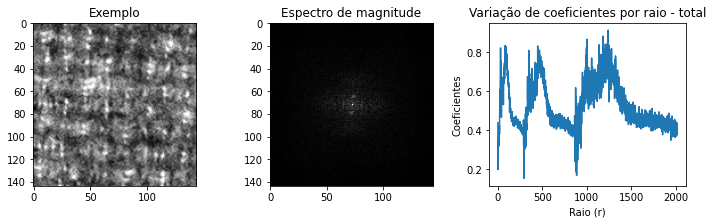

In [ ]:
example = 3
block = 0
x = input[example]

plt.figure(figsize=(12,3))
plt.subplot(131), plt.imshow(sliced_data[example, block,:,:], cmap='gray')
plt.title('Exemplo')
plt.subplot(132), plt.imshow(dft_data[example, block,:,:], cmap='gray')
plt.title('Espectro de magnitude')
plt.subplot(133), plt.plot(x)
plt.title('Variação de coeficientes por raio - total'), plt.xlabel('Raio (r)'), plt.ylabel('Coeficientes')
plt.show()

In [ ]:
with tf.device('/CPU:0'):
  input_test, sliced_data_test, dft_data_test = PreProcess(x_test, level=2, r=1).processing()

In [ ]:
input_test.shape ### test set shape

TensorShape([1120, 2016])

In [ ]:
sliced_data_test.shape #ultima parte do pre-processamento: 16 blocos 144x144

TensorShape([1120, 16, 144, 144])

In [ ]:
np.save('input_test_exp2_w1_l2_radial.npy', input_test)

In [ ]:
!nvidia-smi

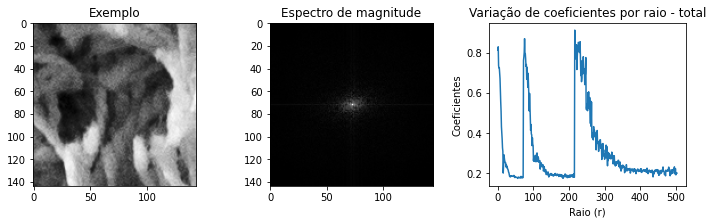

In [ ]:
example = 0
block = 0
x = input_test[example]

plt.figure(figsize=(12,3))
plt.subplot(131), plt.imshow(sliced_data_test[example, block,:,:], cmap='gray')
plt.title('Exemplo')
plt.subplot(132), plt.imshow(dft_data_test[example, block,:,:], cmap='gray')
plt.title('Espectro de magnitude')
plt.subplot(133), plt.plot(x)
plt.title('Variação de coeficientes por raio - total'), plt.xlabel('Raio (r)'), plt.ylabel('Coeficientes')
plt.show()

#### Data Load

In [ ]:
### Saved Pre-Processed data LOAD ###
input = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/input_train_exp2_w1_l2_square.npy')) ### train 96+192+384=672 / 72+144+288=504
input_test = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/input_test_exp2_w1_l2_square.npy')) ### test

In [ ]:
input_1 =  input[:,:288]
input_test_1 = input_test[:,:288]

In [ ]:
input_1.shape

TensorShape([3360, 288])

In [ ]:
input_2 =  input[:, :288*3]
input_test_2 = input_test[:,:288*3]

In [ ]:
input_2.shape

TensorShape([3360, 864])

In [ ]:
input_test.shape

TensorShape([1120, 2016])

In [ ]:
input_3 =  input[:,:]
input_test_3 = input_test[:,:]

In [ ]:
input_3.shape

TensorShape([3360, 2016])

#### Custom Layer

In [ ]:
### frequency layer constrution ###
class FreqLayer(Layer):
  def __init__(self, units, kernel_initializer=None, **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.kernel_initializer = kernel_initializer
  def build(self, batch_input_shape):
    self.kernel = self.add_weight(
        name='kernel',
        shape=[batch_input_shape[-1]], #(weights,)
        initializer=self.kernel_initializer,
        trainable=True)
    super().build(batch_input_shape) # must be at the end
  def call(self, X):
    f = X*self.kernel
    return f
  def compute_output_shape(self, batch_input_shape):
    return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units]) #[examples,1]

#### Model_Input3

In [ ]:
tf.random.set_seed(s)
init = 'glorot_normal'
function = 'relu'

model = Sequential([
    FreqLayer(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=-2, stddev=0.01)),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init), 
    Dense(28, activation='softmax')])

In [ ]:
### inverse time decay  ###
inversetime_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate = 0.01, #0.01 - opt2 lr=0.001
  decay_steps = input.shape[0]/10,
  decay_rate = 0.005) #0.005 - opt2 dr=0.02/0.03/0.04/0.05/0.09 obtive 99,73

d_m=0.8 #momentum - dense layers

### optimizers ###
opt0 = SGD(learning_rate=inversetime_decay, momentum=d_m) #0.001 
opt1 = RMSprop(learning_rate=inversetime_decay, momentum=d_m) #lr=0.001 dr=0.02
opt2 = Adam(learning_rate=inversetime_decay) #lr=0.001 dr=0.02
opt3 = Nadam(learning_rate=0.001) #lr=0.001 dr=0.02 //does not support scheduled decay
opt4 = tfrs.experimental.optimizers.CompositeOptimizer([
      (SGD(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt5 = tfrs.experimental.optimizers.CompositeOptimizer([
      (RMSprop(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt6 = tfa.optimizers.AdamW(weight_decay = 1/4*0.001)
opt7 = tfa.optimizers.COCOB(alpha=1000)
opt8 = tfa.optimizers.LAMB(learning_rate=0.001)

model.compile(optimizer=opt4, loss='categorical_crossentropy', metrics=['accuracy'])
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=500) # patience = 15
history = model.fit(input, y_train, epochs=500, batch_size=10, verbose=1, shuffle=True)

Epoch 1/500
336/336 [==============================] - 3s 3ms/step - loss: 1.7427 - accuracy: 0.4455
Epoch 2/500
336/336 [==============================] - 1s 3ms/step - loss: 0.7305 - accuracy: 0.7512
Epoch 3/500
336/336 [==============================] - 1s 3ms/step - loss: 0.4415 - accuracy: 0.8482
Epoch 4/500
336/336 [==============================] - 1s 3ms/step - loss: 0.4349 - accuracy: 0.8482
Epoch 5/500
336/336 [==============================] - 1s 3ms/step - loss: 0.2754 - accuracy: 0.9039
Epoch 6/500
336/336 [==============================] - 1s 3ms/step - loss: 0.3351 - accuracy: 0.8940
Epoch 7/500
336/336 [==============================] - 1s 3ms/step - loss: 0.2708 - accuracy: 0.9024
Epoch 8/500
336/336 [==============================] - 1s 3ms/step - loss: 0.3043 - accuracy: 0.9125
Epoch 9/500
336/336 [==============================] - 1s 3ms/step - loss: 0.2600 - accuracy: 0.9054
Epoch 10/500
336/336 [==============================] - 1s 3ms/step - loss: 0.2001 - accura

KeyboardInterrupt: ignored

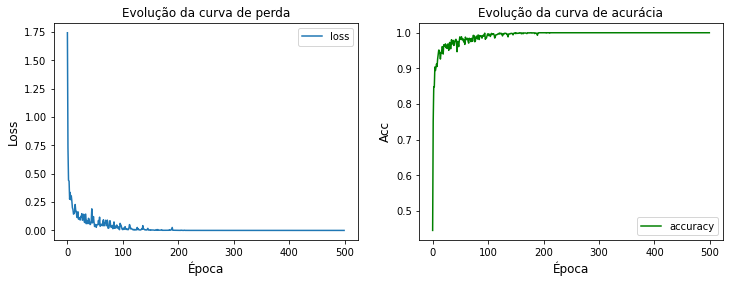

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
scores = model.evaluate(input_test, y_test)
print('\n%s : %.2f%%' % (model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9973

accuracy : 99.73%


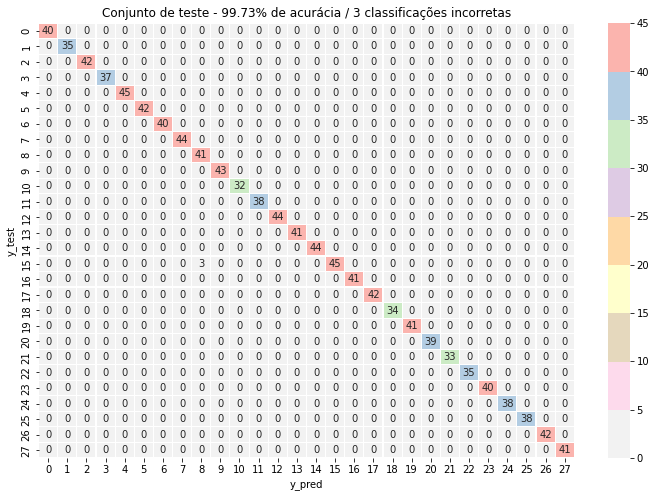

In [ ]:
y_pred = model.predict(input_test)
plt.figure(figsize = (12,8))
cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
acc = np.trace(cm)/input_test.shape[0] * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros))
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
dic = {0:'blanket1',1:'blanket2',2:'canvas1',3:'ceiling1',4:'ceiling2',5:'cushion1',
       6:'floor1',7:'floor2',8:'grass1',9:'lentils1',10:'linseeds1',11:'oatmeal1',
       12:'pearlsugar1',13:'rice1',14:'rice2',15:'rug1',16:'sand1',17:'scarf1',
       18:'scarf2',19:'screen1',20:'seat1',21:'seat2',22:'sesameseeds1',23:'stone1',
       24:'stone2',25:'stone3',26:'stoneslab1',27:'wall1'}

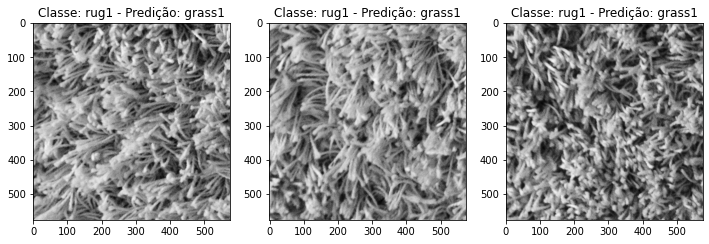

In [ ]:
dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
indices = np.where(dif!=0)[0]

plt.figure(figsize=(12,6))
plt.subplot(131), plt.imshow(tf.squeeze(x_test[indices[0]]), cmap='gray')
r1 = tf.argmax(y_test, axis=1)[indices[0]]
f1 = tf.argmax(y_pred, axis=1)[indices[0]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
plt.subplot(132), plt.imshow(tf.squeeze(x_test[indices[1]]), cmap='gray')
r2 = tf.argmax(y_test, axis=1)[indices[1]]
f2 = tf.argmax(y_pred, axis=1)[indices[1]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
plt.subplot(133), plt.imshow(tf.squeeze(x_test[indices[2]]), cmap='gray')
r3 = tf.argmax(y_test, axis=1)[indices[2]]
f3 = tf.argmax(y_pred, axis=1)[indices[2]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r3)], dic[int(f3)]))
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
freq_layer (FreqLayer)       (None, 2016)              2016      
_________________________________________________________________
dense (Dense)                (None, 128)               258176    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 28)                3612      
Total params: 280,316
Trainable params: 280,316
Non-trainable params: 0
_________________________________________________________________


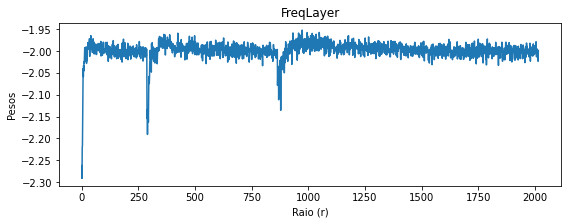

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(model.get_weights()[0])
plt.title('FreqLayer')
plt.xlabel('Raio (r)'), plt.ylabel('Pesos')
plt.show()

#### Model_Input2

In [ ]:
tf.random.set_seed(s)
init = 'glorot_normal'
function = 'relu'

model = Sequential([
    FreqLayer(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=-2, stddev=0.01)),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init), 
    Dense(28, activation='softmax')])

In [ ]:
### inverse time decay  ###
inversetime_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate = 0.01, #0.01 - opt2 lr=0.001
  decay_steps = input_2.shape[0]/10,
  decay_rate = 0.005) #0.005 - opt2 dr=0.02/0.03/0.04/0.05/0.09 obtive 99,73

d_m=0.8 #momentum - dense layers

### optimizers ###
opt0 = SGD(learning_rate=inversetime_decay, momentum=d_m) #0.001 
opt1 = RMSprop(learning_rate=inversetime_decay, momentum=d_m) #lr=0.001 dr=0.02
opt2 = Adam(learning_rate=inversetime_decay) #lr=0.001 dr=0.02
opt3 = Nadam(learning_rate=0.001) #lr=0.001 dr=0.02 //does not support scheduled decay
opt4 = tfrs.experimental.optimizers.CompositeOptimizer([
      (SGD(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt5 = tfrs.experimental.optimizers.CompositeOptimizer([
      (RMSprop(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt6 = tfa.optimizers.AdamW(weight_decay = 1/4*0.001)
opt7 = tfa.optimizers.COCOB(alpha=1000)
opt8 = tfa.optimizers.LAMB(learning_rate=0.001)

model.compile(optimizer=opt4, loss='categorical_crossentropy', metrics=['accuracy'])
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=500) # patience = 15
history = model.fit(input_2, y_train, epochs=500, batch_size=10, verbose=1, shuffle=True)

Epoch 1/500
336/336 [==============================] - 4s 2ms/step - loss: 1.7417 - accuracy: 0.4563
Epoch 2/500
336/336 [==============================] - 1s 2ms/step - loss: 0.6360 - accuracy: 0.7967
Epoch 3/500
336/336 [==============================] - 1s 2ms/step - loss: 0.3716 - accuracy: 0.8765
Epoch 4/500
336/336 [==============================] - 1s 2ms/step - loss: 0.3183 - accuracy: 0.8929
Epoch 5/500
336/336 [==============================] - 1s 2ms/step - loss: 0.2192 - accuracy: 0.9250
Epoch 6/500
336/336 [==============================] - 1s 2ms/step - loss: 0.1908 - accuracy: 0.9333
Epoch 7/500
336/336 [==============================] - 1s 2ms/step - loss: 0.1729 - accuracy: 0.9384
Epoch 8/500
336/336 [==============================] - 1s 2ms/step - loss: 0.1668 - accuracy: 0.9408
Epoch 9/500
336/336 [==============================] - 1s 2ms/step - loss: 0.2121 - accuracy: 0.9327
Epoch 10/500
336/336 [==============================] - 1s 2ms/step - loss: 0.1608 - accura

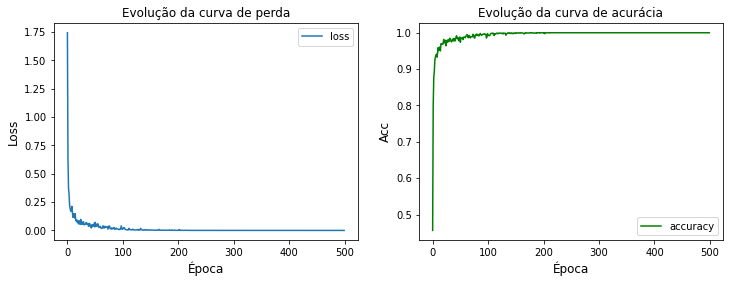

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
scores = model.evaluate(input_test_2, y_test)
print('\n%s : %.2f%%' % (model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 0.9946

accuracy : 99.46%


35/35 [==============================] - 0s 1ms/step


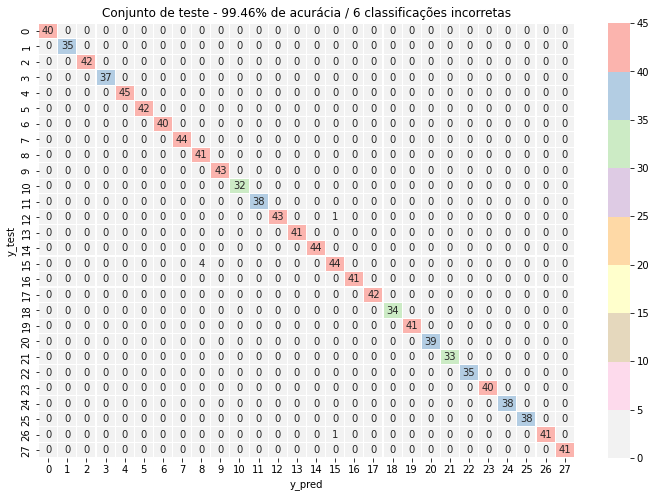

In [ ]:
y_pred = model.predict(input_test_2)
plt.figure(figsize = (12,8))
cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
acc = np.trace(cm)/input_test_2.shape[0] * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros))
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
dic = {0:'blanket1',1:'blanket2',2:'canvas1',3:'ceiling1',4:'ceiling2',5:'cushion1',
       6:'floor1',7:'floor2',8:'grass1',9:'lentils1',10:'linseeds1',11:'oatmeal1',
       12:'pearlsugar1',13:'rice1',14:'rice2',15:'rug1',16:'sand1',17:'scarf1',
       18:'scarf2',19:'screen1',20:'seat1',21:'seat2',22:'sesameseeds1',23:'stone1',
       24:'stone2',25:'stone3',26:'stoneslab1',27:'wall1'}

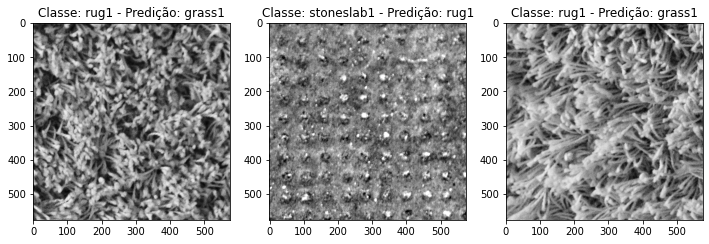

In [ ]:
dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
indices = np.where(dif!=0)[0]

plt.figure(figsize=(12,6))
plt.subplot(131), plt.imshow(tf.squeeze(x_test[indices[0]]), cmap='gray')
r1 = tf.argmax(y_test, axis=1)[indices[0]]
f1 = tf.argmax(y_pred, axis=1)[indices[0]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
plt.subplot(132), plt.imshow(tf.squeeze(x_test[indices[1]]), cmap='gray')
r2 = tf.argmax(y_test, axis=1)[indices[1]]
f2 = tf.argmax(y_pred, axis=1)[indices[1]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
plt.subplot(133), plt.imshow(tf.squeeze(x_test[indices[2]]), cmap='gray')
r3 = tf.argmax(y_test, axis=1)[indices[2]]
f3 = tf.argmax(y_pred, axis=1)[indices[2]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r3)], dic[int(f3)]))
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freq_layer (FreqLayer)      (None, 864)               864       
                                                                 
 dense (Dense)               (None, 128)               110720    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 28)                3612      
                                                                 
Total params: 131,708
Trainable params: 131,708
Non-trainable params: 0
_________________________________________________________________


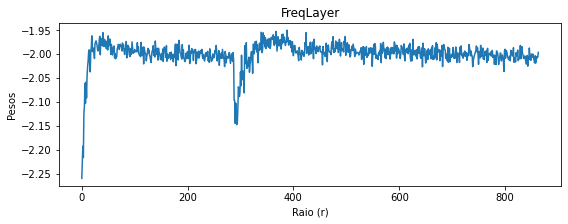

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(model.get_weights()[0])
plt.title('FreqLayer')
plt.xlabel('Raio (r)'), plt.ylabel('Pesos')
plt.show()

#### Model_Input1

In [ ]:
tf.random.set_seed(s)
init = 'glorot_normal'
function = 'relu'

model = Sequential([
    FreqLayer(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=-2, stddev=0.01)),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init), 
    Dense(28, activation='softmax')])

In [ ]:
### inverse time decay  ###
inversetime_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate = 0.01, #0.01 - opt2 lr=0.001
  decay_steps = input_1.shape[0]/10,
  decay_rate = 0.005) #0.005 - opt2 dr=0.02/0.03/0.04/0.05/0.09 obtive 99,73

d_m=0.8 #momentum - dense layers

### optimizers ###
opt0 = SGD(learning_rate=inversetime_decay, momentum=d_m) #0.001 
opt1 = RMSprop(learning_rate=inversetime_decay, momentum=d_m) #lr=0.001 dr=0.02
opt2 = Adam(learning_rate=inversetime_decay) #lr=0.001 dr=0.02
opt3 = Nadam(learning_rate=0.001) #lr=0.001 dr=0.02 //does not support scheduled decay
opt4 = tfrs.experimental.optimizers.CompositeOptimizer([
      (SGD(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt5 = tfrs.experimental.optimizers.CompositeOptimizer([
      (RMSprop(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt6 = tfa.optimizers.AdamW(weight_decay = 1/4*0.001)
opt7 = tfa.optimizers.COCOB(alpha=1000)
opt8 = tfa.optimizers.LAMB(learning_rate=0.001)

model.compile(optimizer=opt4, loss='categorical_crossentropy', metrics=['accuracy'])
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=500) # patience = 15
history = model.fit(input_1, y_train, epochs=500, batch_size=10, verbose=1, shuffle=True)

Epoch 1/500
336/336 [==============================] - 1s 2ms/step - loss: 1.8580 - accuracy: 0.4452
Epoch 2/500
336/336 [==============================] - 1s 2ms/step - loss: 0.6296 - accuracy: 0.8101
Epoch 3/500
336/336 [==============================] - 1s 2ms/step - loss: 0.3841 - accuracy: 0.8717
Epoch 4/500
336/336 [==============================] - 1s 2ms/step - loss: 0.2460 - accuracy: 0.9170
Epoch 5/500
336/336 [==============================] - 1s 2ms/step - loss: 0.1885 - accuracy: 0.9345
Epoch 6/500
336/336 [==============================] - 1s 2ms/step - loss: 0.2213 - accuracy: 0.9324
Epoch 7/500
336/336 [==============================] - 1s 2ms/step - loss: 0.1486 - accuracy: 0.9491
Epoch 8/500
336/336 [==============================] - 1s 2ms/step - loss: 0.1547 - accuracy: 0.9455
Epoch 9/500
336/336 [==============================] - 1s 2ms/step - loss: 0.1705 - accuracy: 0.9464
Epoch 10/500
336/336 [==============================] - 1s 2ms/step - loss: 0.1392 - accura

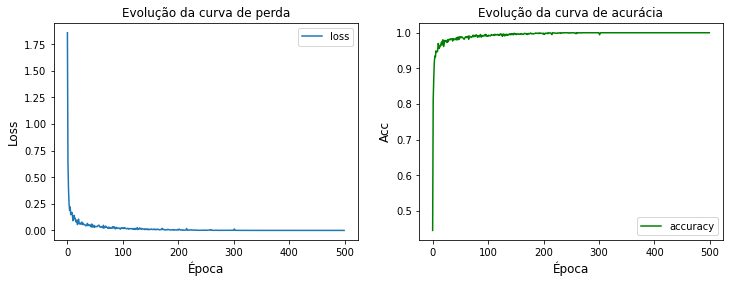

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
scores = model.evaluate(input_test_1, y_test)
print('\n%s : %.2f%%' % (model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 0s 2ms/step - loss: 0.0289 - accuracy: 0.9902

accuracy : 99.02%


35/35 [==============================] - 0s 1ms/step


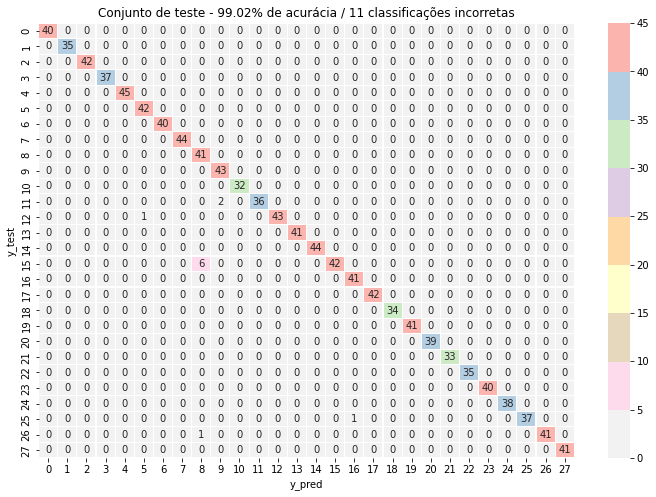

In [ ]:
y_pred = model.predict(input_test_1)
plt.figure(figsize = (12,8))
cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
acc = np.trace(cm)/input_test_1.shape[0] * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros))
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
dic = {0:'blanket1',1:'blanket2',2:'canvas1',3:'ceiling1',4:'ceiling2',5:'cushion1',
       6:'floor1',7:'floor2',8:'grass1',9:'lentils1',10:'linseeds1',11:'oatmeal1',
       12:'pearlsugar1',13:'rice1',14:'rice2',15:'rug1',16:'sand1',17:'scarf1',
       18:'scarf2',19:'screen1',20:'seat1',21:'seat2',22:'sesameseeds1',23:'stone1',
       24:'stone2',25:'stone3',26:'stoneslab1',27:'wall1'}

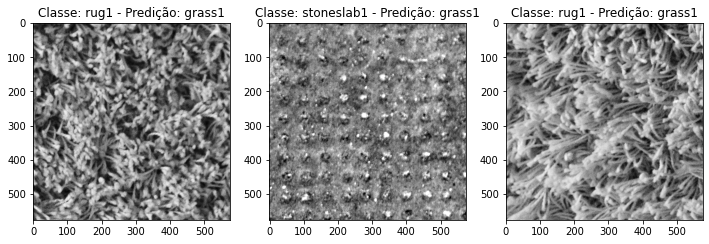

In [ ]:
dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
indices = np.where(dif!=0)[0]

plt.figure(figsize=(12,6))
plt.subplot(131), plt.imshow(tf.squeeze(x_test[indices[0]]), cmap='gray')
r1 = tf.argmax(y_test, axis=1)[indices[0]]
f1 = tf.argmax(y_pred, axis=1)[indices[0]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
plt.subplot(132), plt.imshow(tf.squeeze(x_test[indices[1]]), cmap='gray')
r2 = tf.argmax(y_test, axis=1)[indices[1]]
f2 = tf.argmax(y_pred, axis=1)[indices[1]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
plt.subplot(133), plt.imshow(tf.squeeze(x_test[indices[2]]), cmap='gray')
r3 = tf.argmax(y_test, axis=1)[indices[2]]
f3 = tf.argmax(y_pred, axis=1)[indices[2]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r3)], dic[int(f3)]))
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freq_layer_1 (FreqLayer)    (None, 288)               288       
                                                                 
 dense_3 (Dense)             (None, 128)               36992     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 28)                3612      
                                                                 
Total params: 57,404
Trainable params: 57,404
Non-trainable params: 0
_________________________________________________________________


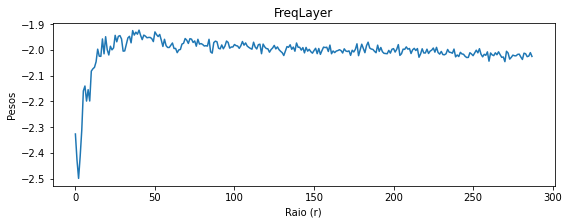

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(model.get_weights()[0])
plt.title('FreqLayer')
plt.xlabel('Raio (r)'), plt.ylabel('Pesos')
plt.show()